## Trajectory inference // CellRank

Author: Lieke L van de Haar (18112020)

__CellRank__

CellRank for directed single-cell fate mapping
Marius Lange, Volker Bergen, Michal Klein, Manu Setty, Bernhard Reuter, Mostafa Bakhti, Heiko Lickert, 
Meshal Ansari, Janine Schniering, Herbert B. Schiller, Dana Pe’er, Fabian J. Theis
doi: https://doi.org/10.1101/2020.10.19.345983 

For detailed information on CellRank: https://github.com/theislab/cellrank 

__Run__ conda activate cellrank __followed by__ jupyter notebook __in order to have the correct environment__

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

#settings
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2
sc.settings.figdir = "../../../figures/DevelopmentalHb/TrajectoryInference/"
scv.settings.figdir = "../../../figures/DevelopmentalHb/TrajectoryInference/"
scv.settings.set_figure_params(dpi=80)

## Import adata

In [3]:
adata = sc.read_h5ad('../../../data/output/DevelopmentalHb/Mar2020_embryo_Hb_Pou4f1_louvain_seurat.h5ad')
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.59 0.41]


AnnData object with n_obs × n_vars = 2773 × 2292
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm', 'louvain'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'plate_colors', 'stage_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [4]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. The first step, estimating the parameters of the dynamical model,  may take a while (~10min). To make sure we only have to run this once, we developed a caching extension called [scachepy](https://github.com/theislab/scachepy). scachepy does not only work for `recover_dynamics`, but it can cache the output of almost any scanpy or scvelo function. To install it, simply run 

```
pip install git+https://github.com/theislab/scachepy
```

In [5]:
try:
    import scachepy
    c = scachepy.Cache('../../../cached_files/basic_tutorial/')
    c.tl.recover_dynamics(adata, force=False)
except ModuleNotFoundError:
    print("You don't seem to have scachepy installed, but that's fine, you just have to be a bit patient (~10min). ")
    scv.tl.recover_dynamics(adata)

Loading data from: `recover_dynamics.pickle`.


In [6]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../../figures/embryo_Hb/Seurat/Cellrank/scvelo__UMAP_scVELO.pdf


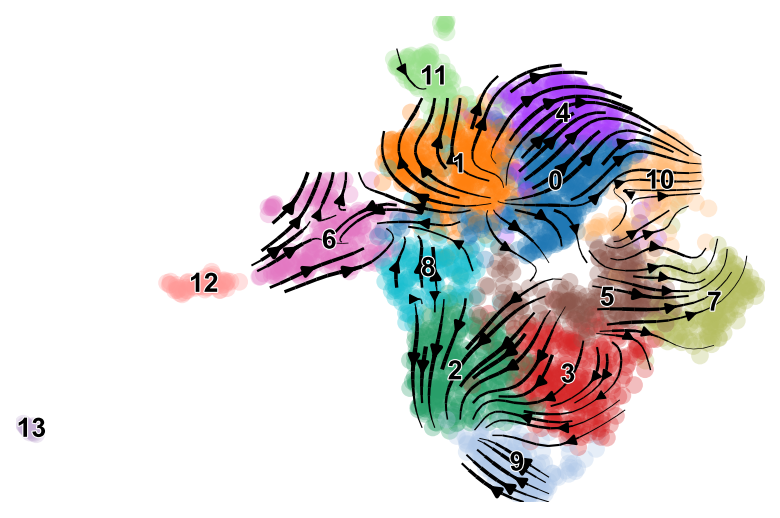

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)
saving figure to file ../../figures/embryo_Hb/Seurat/Cellrank/scvelo__tSNE_scVELO.pdf


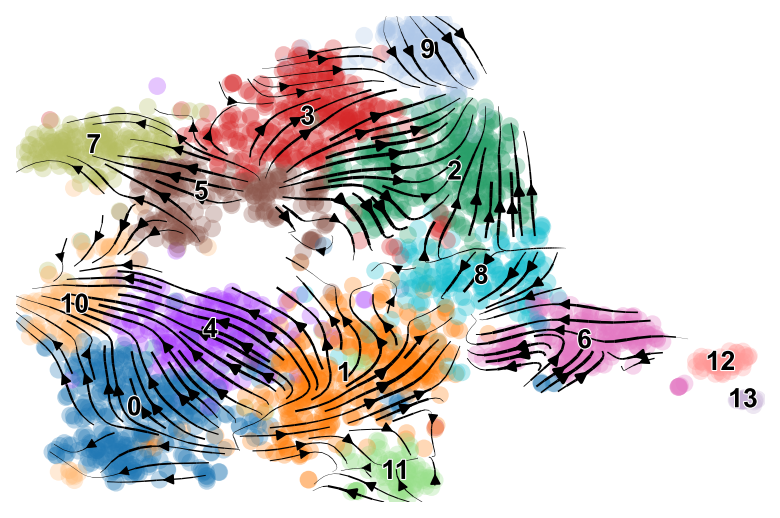

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='tsne', legend_fontsize=12, title='', smooth=.8, min_mass=4, save="_tSNE_scVELO.pdf")

## Run CellRank

The number of terminal states can be defined by the user. Here we use 7. 

In [8]:
cr.tl.terminal_states(adata, cluster_key='louvain', weight_connectivities=0.2, n_states= 7)

Computing transition matrix based on velocity correlations using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode



Setting `softmax_scale=6.0415`



    Finish (0:00:10)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on connectivities
    Finish (0:00:00)
Computing Schur decomposition
Unable to import PETSc or SLEPc.
You can install it from: https://slepc4py.readthedocs.io/en/stable/install.html
Defaulting to `method='brandts'`.
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:20)
Computing `7` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:02)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`


The most important parameters in the above function are:

 - `estimator`: this determines what's going to behind the scenes to compute the terminal states. Options are `cr.tl.estimators.CFLARE` ("Clustering and Filtering of Left and Right Eigenvectors") or `cr.tl.estimators.GPCCA` ("[Generalized Perron Cluster Cluster Analysis](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00079)"). The latter is the default, it computes terminal states by coarse graining the velocity-derived Markov chain into a set of macrostates that represent the slow-time scale dynamics of the process, i.e. it finds the states that you are unlikely to leave again, once you have entered them. 
 - `cluster_key`: takes a key from `adata.obs` to retrieve pre-computed cluster labels, i.e. 'clusters' or 'louvain'. These labels are then mapped onto the set of terminal states, to associate a name and a color with each state.
 - `n_states`: number of expected terminal states. This parameter is optional - if it's not provided, this number is estimated from the so-called 'eigengap heuristic' of the spectrum of the transition matrix. 
 - `method`: This is only relevant for the estimator `GPCCA`. It determines the way in which we compute and sort the [real Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition). The default, `krylov`, is an iterative procedure that works with sparse matrices which allows the method to scale to very large cell numbers. It relies on the libraries [SLEPSc](https://slepc.upv.es/) and [PETSc](https://www.mcs.anl.gov/petsc/), which you will have to install separately, see our [installation instructions](https://cellrank.readthedocs.io/en/latest/installation.html). If your dataset is small (<5k cells), and you don't want to install these at the moment, use `method='brandts'`. The results will be the same, the difference is that `brandts` works with dense matrices and won't scale to very large cells numbers.   
 - `weight_connectivities`: additionally to the velocity-based transition probabilities, we use a transition matrix computed on the basis of transcriptomic similarities to make the algorithm more robust. Essentially, we are taking a weighted mean of these two sources of inforamtion, where the weight for transcriptomic similarities is defined by `weight_connectivities`.

When running the above command, CellRank adds a key `terminal_states` to adata.obs and the result can be plotted as:

saving figure to file ../../figures/embryo_Hb/Seurat/Cellrank/scvelo__terminalstates_7.pdf


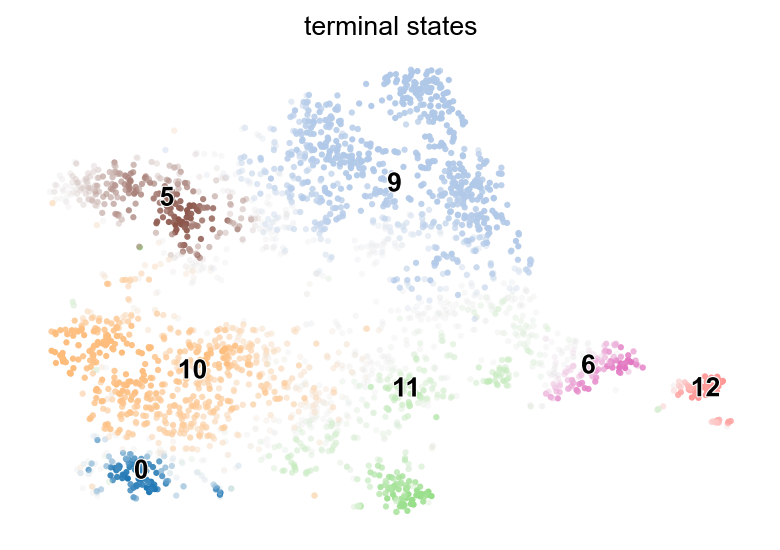

In [9]:
cr.pl.terminal_states(adata, basis='tsne',save = "_terminalstates_7.pdf")

## Identify initial states

The same sort of analysis can now be repeated for the initial states, only that we use the function `cr.tl.initial_states` this time:

Using precomputed transition matrix
Computing eigendecomposition of the transition matrix
Adding `.eigendecomposition`
       `adata.uns['eig_bwd']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `.eigendecomposition`
       `adata.uns['eig_bwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:25)
Computing `2` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `adata.obsm['macrostates_bwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
saving figure to file ../../figures/embryo_Hb/Seurat/Cellrank/scvelo__initialstates.pdf


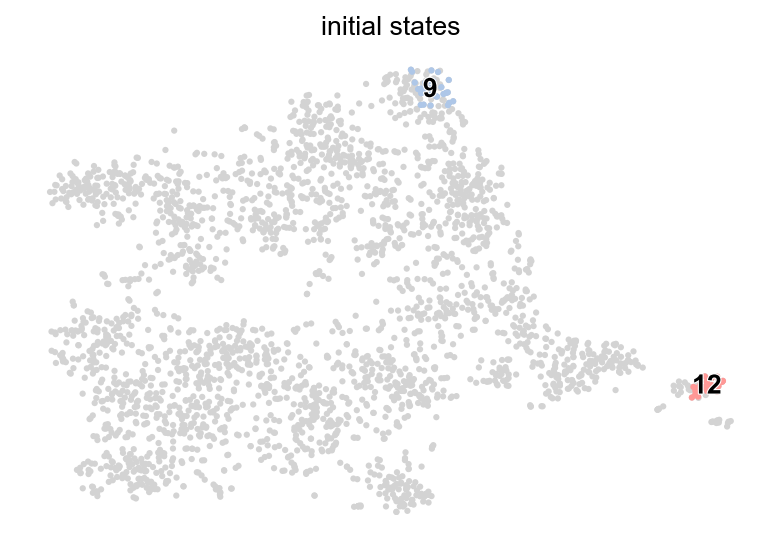

In [20]:
cr.tl.initial_states(adata, cluster_key='louvain') 
cr.pl.initial_states(adata, discrete=True,  basis='tsne', save = "_initialstates.pdf")

This seems to give always the same results when you change the terminal state number. Always its 12 and 9. 

## Compute fate maps

Once we know the terminal states, we can compute associated fate maps - for each cell, we ask how likely is the cell to develop towards each of the identified terminal states. 

Computing lineage probabilities towards terminal states
Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:00)


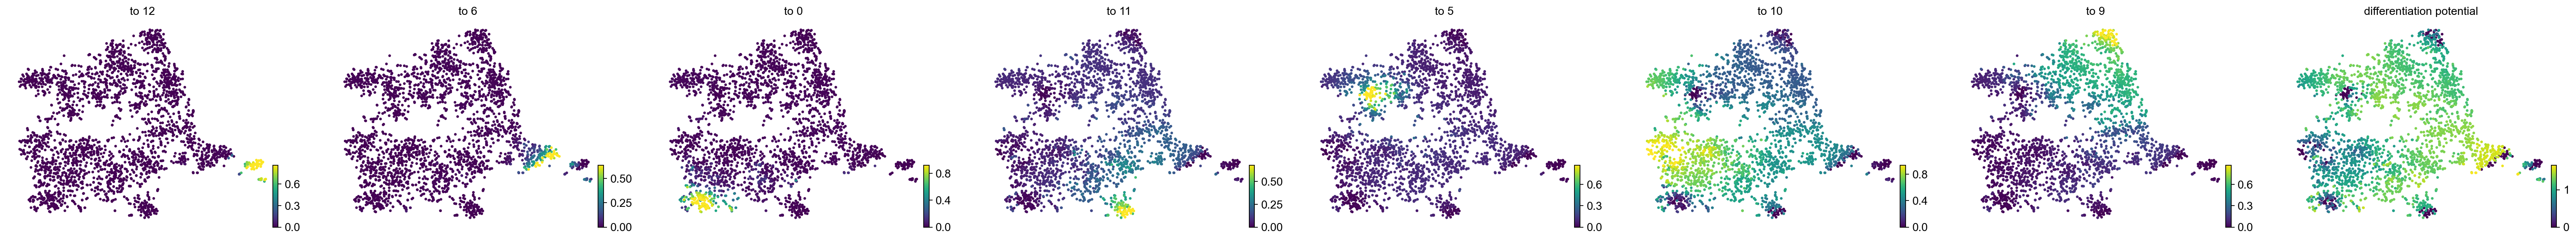

In [11]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False,  basis='tsne')

We can aggregate the above into a single, global fate map where we associate each terminal state with color and use the intensity of that color to show the fate of each individual cell:

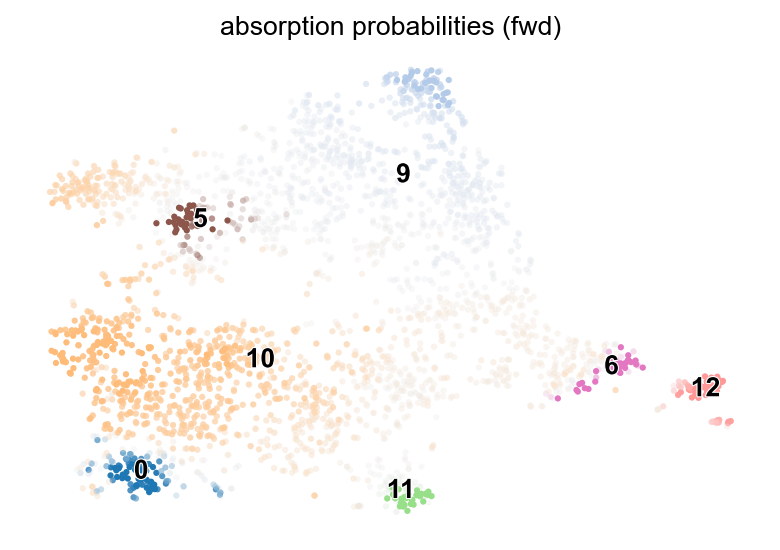

In [12]:
cr.pl.lineages(adata, same_plot=True,  basis='tsne')

## Directed PAGA

 
We can further aggragate the individual fate maps into a cluster-level fate map using an adapted version of [PAGA](https://scvelo.readthedocs.io/scvelo.tl.paga.html#scvelo.tl.paga) with directed edges. We first compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time) with CellRank identified `root_key` and `end_key`, which are the probabilities of being an initial or a terminal state, respectively.

In [23]:
scv.tl.recover_latent_time(adata, root_key='initial_states_probs', end_key='terminal_states_probs')

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:04) --> added 
    'latent_time', shared time (adata.obs)


Next, we can use the inferred pseudotime along with the initial and terminal states probabilities to compute the directed PAGA.

In [24]:
scv.tl.paga(adata, groups='louvain', root_key='initial_states_probs', end_key='terminal_states_probs', 
            use_time_prior='velocity_pseudotime')

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


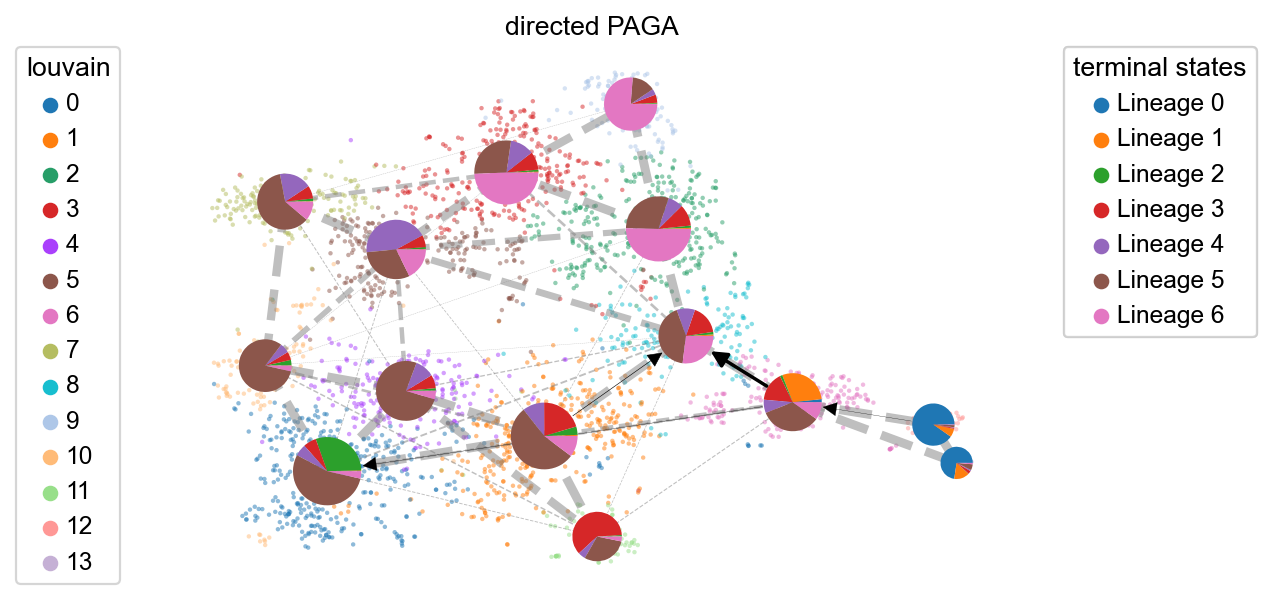

In [25]:
cr.pl.cluster_fates(adata, mode="paga_pie", cluster_key="louvain", basis='tsne',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
                    node_size_scale=5, edge_width_scale=1, max_edge_width=4, title='directed PAGA', save = "_terminalstates_5.pdf")

We use pie charts to show cell fates averaged per cluster. Edges between clusters are given by transcriptomic similarity between the clusters, just as in normal [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga). 


Given the fate maps/probabilistic trajectories, we can ask interesting questions like:

- How does expression of a given gene vary along a specified lineage/trajectory ([cellrank.pl.gene_trends](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.gene_trends.html#cellrank.pl.gene_trends) and [cellrank.pl.heatmap](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.heatmap.html#cellrank.pl.heatmap)?
- How plastic are different cellular subpopulations ([cellrank.pl.cluster_fates(adata, ..., mode='violin')](https://cellrank.readthedocs.io/en/latest/gen_modules/cellrank.pl.cluster_fates.html#cellrank.pl.cluster_fates)?

To find out more, check out the CellRank [API](https://cellrank.readthedocs.io/en/latest/api.html#module-cellrank.pl). 

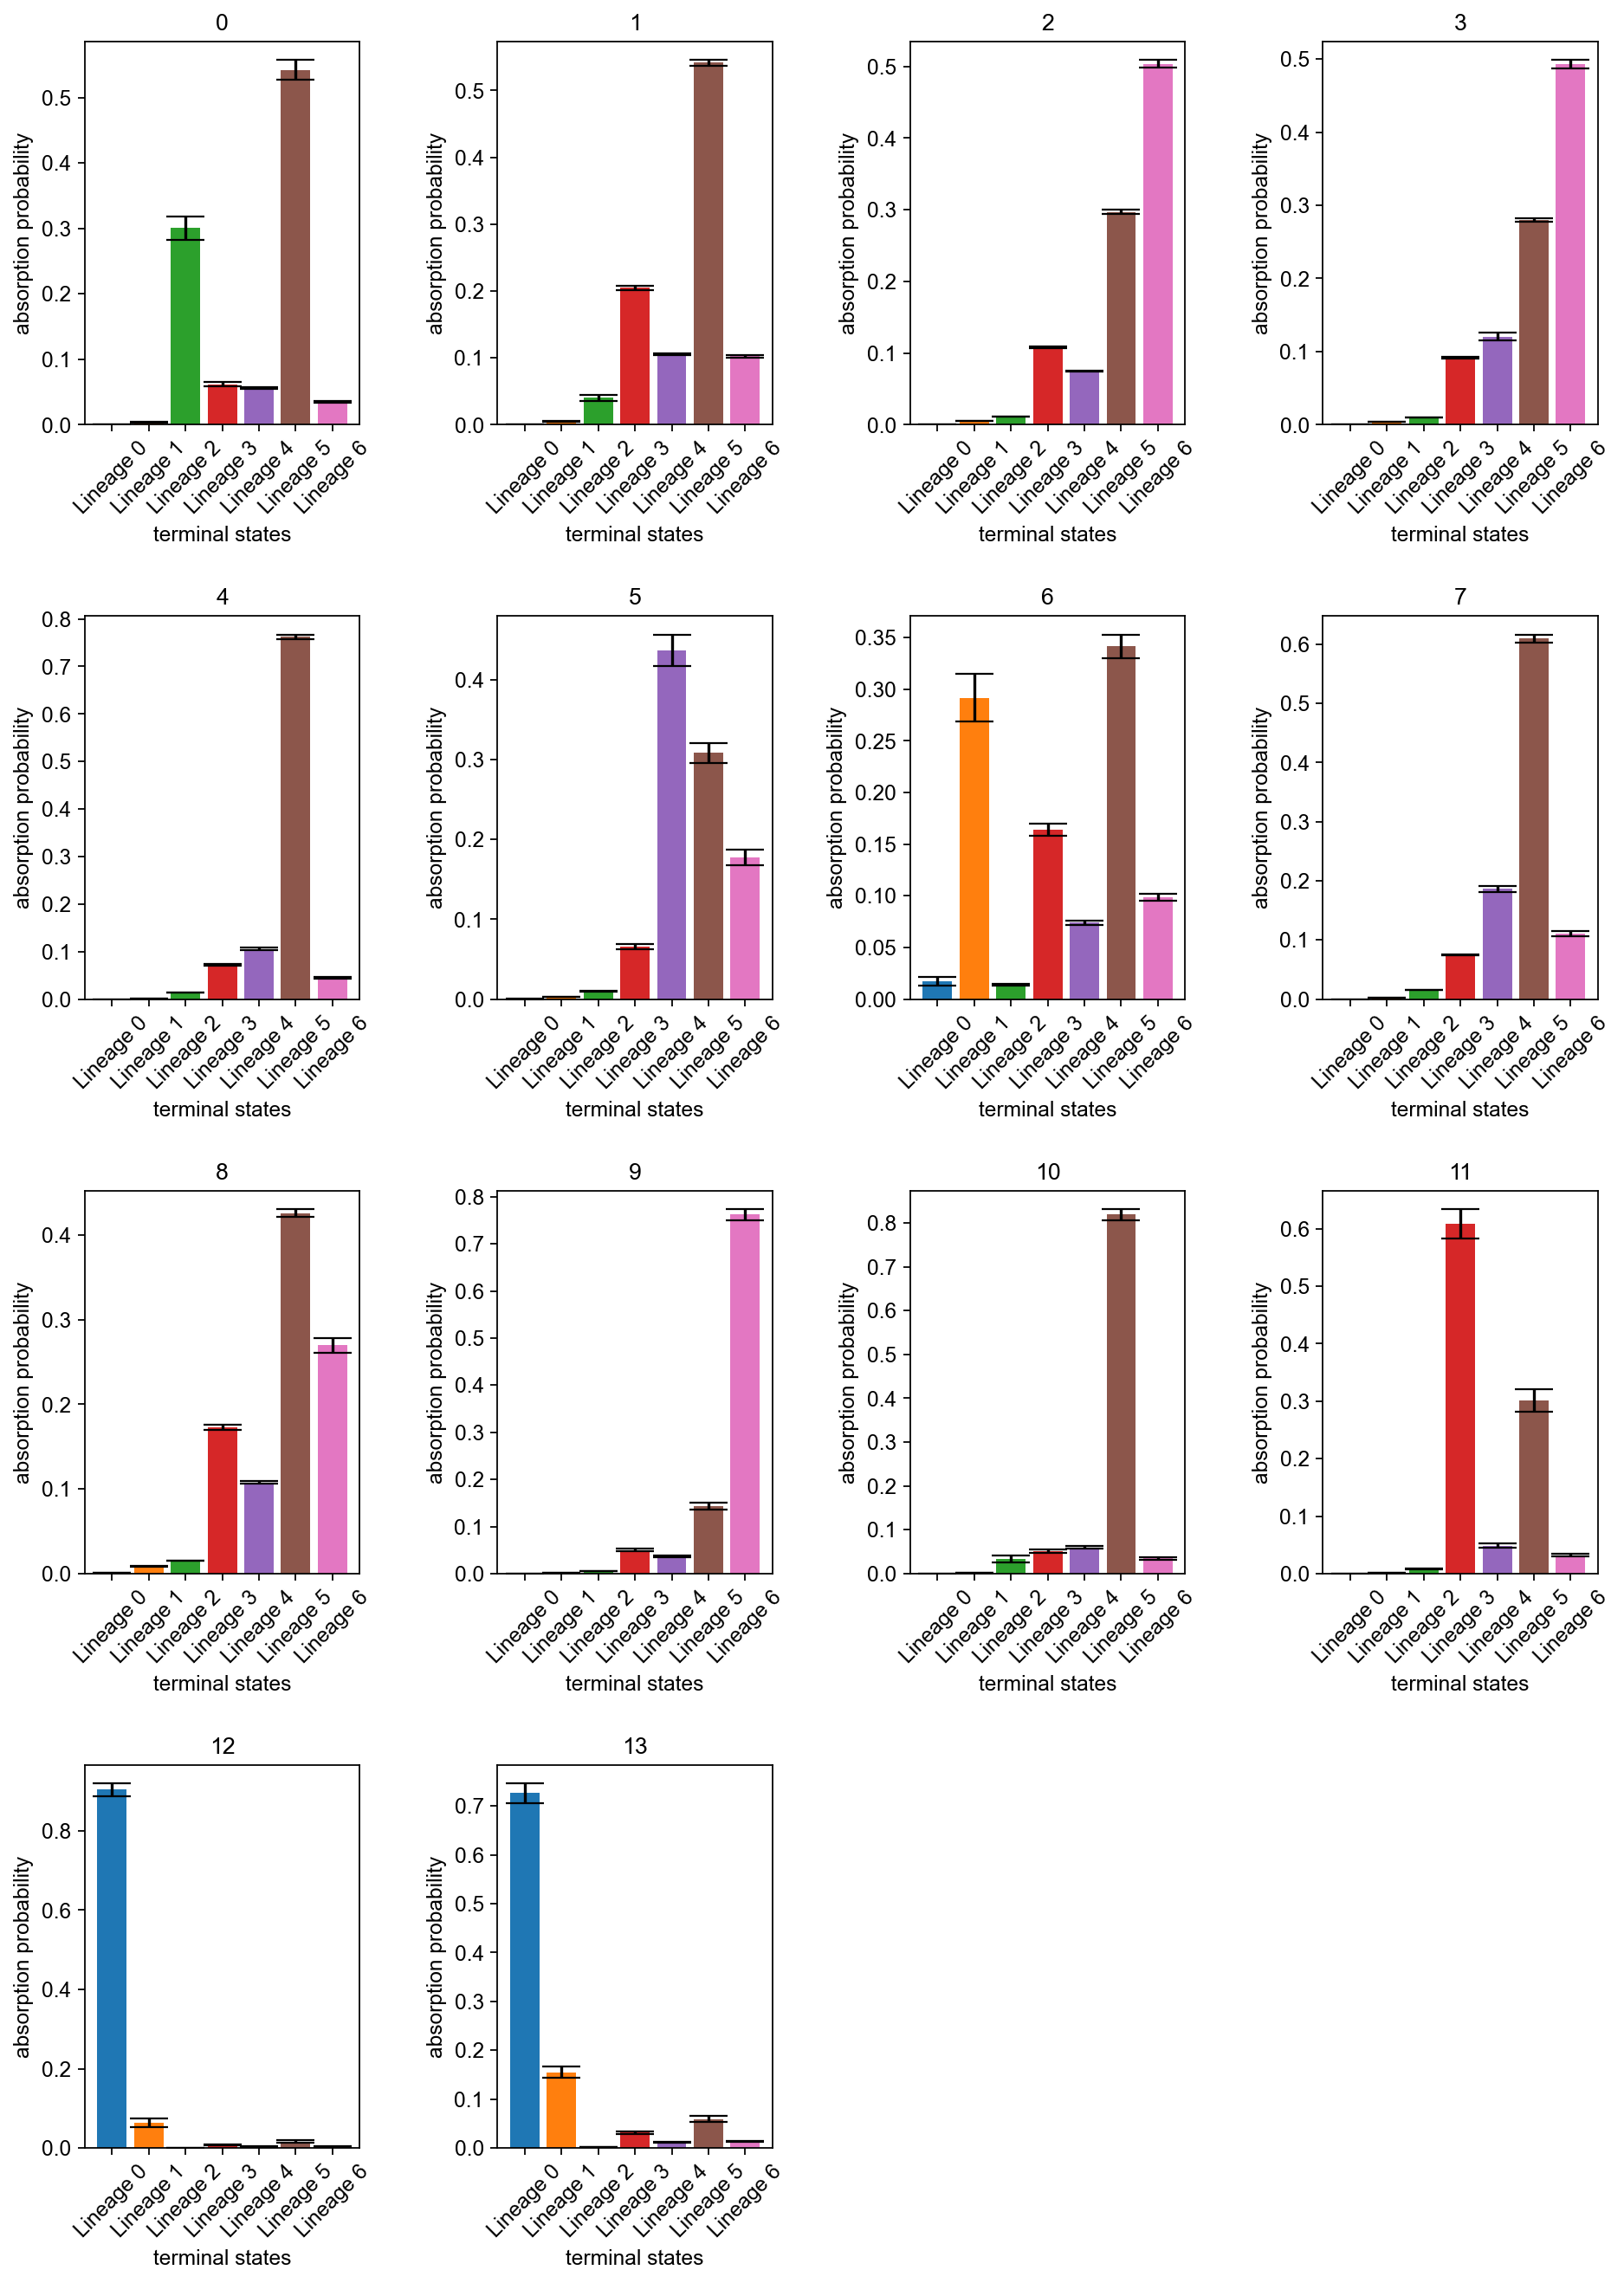

In [26]:
cr.pl.cluster_fates(adata, mode="bar",cluster_key="louvain")

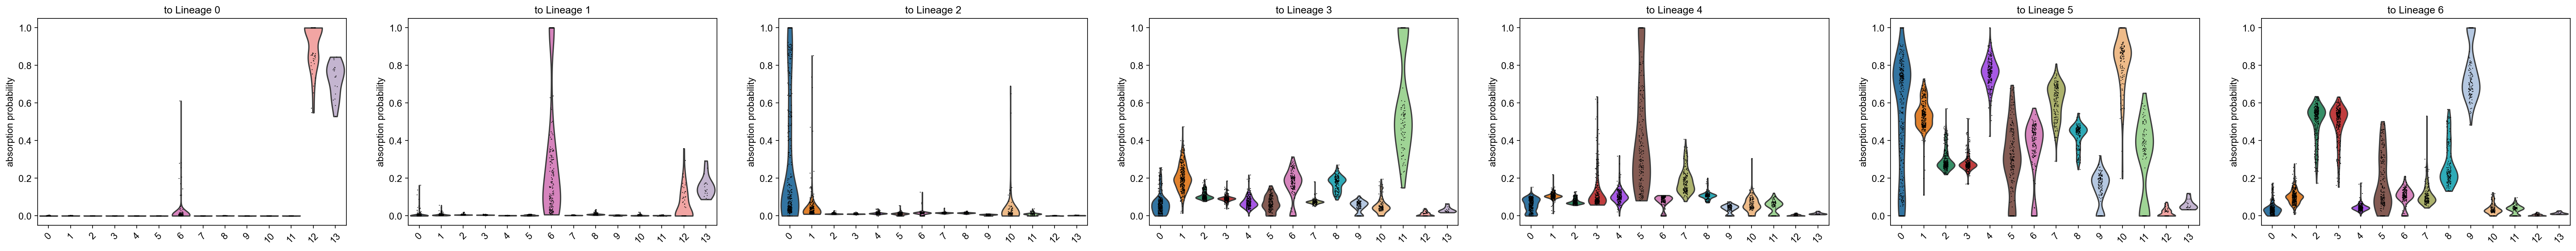

In [27]:
cr.pl.cluster_fates(adata, mode="violin", cluster_key="louvain")

## Compute lineage drivers

We can compute the driver genes for all or just the subset of lineages. We can also restric this to some subset of clusters by specifying `clusters=...` (not shown below).

In [13]:
cr.tl.lineage_drivers(adata, use_raw=True)

Computing correlations for lineages `['12' '6' '0' '11' '5' '10' '9']` restricted to clusters `None` in layer `X` with `use_raw=True`
Adding `.lineage_drivers`
       `adata.raw.var['to 12']`
       `adata.raw.var['to 6']`
       `adata.raw.var['to 0']`
       `adata.raw.var['to 11']`
       `adata.raw.var['to 5']`
       `adata.raw.var['to 10']`
       `adata.raw.var['to 9']`
    Finish (0:00:09)


In [ ]:
cr.pl.lineage_drivers(adata, lineage="to 12", n_genes=5)

Define cluster 12 as the initial root state 

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)
saving figure to file ../../figures/embryo_Hb/Seurat/Cellrank/scvelo_cellrank_latent_time.pdf


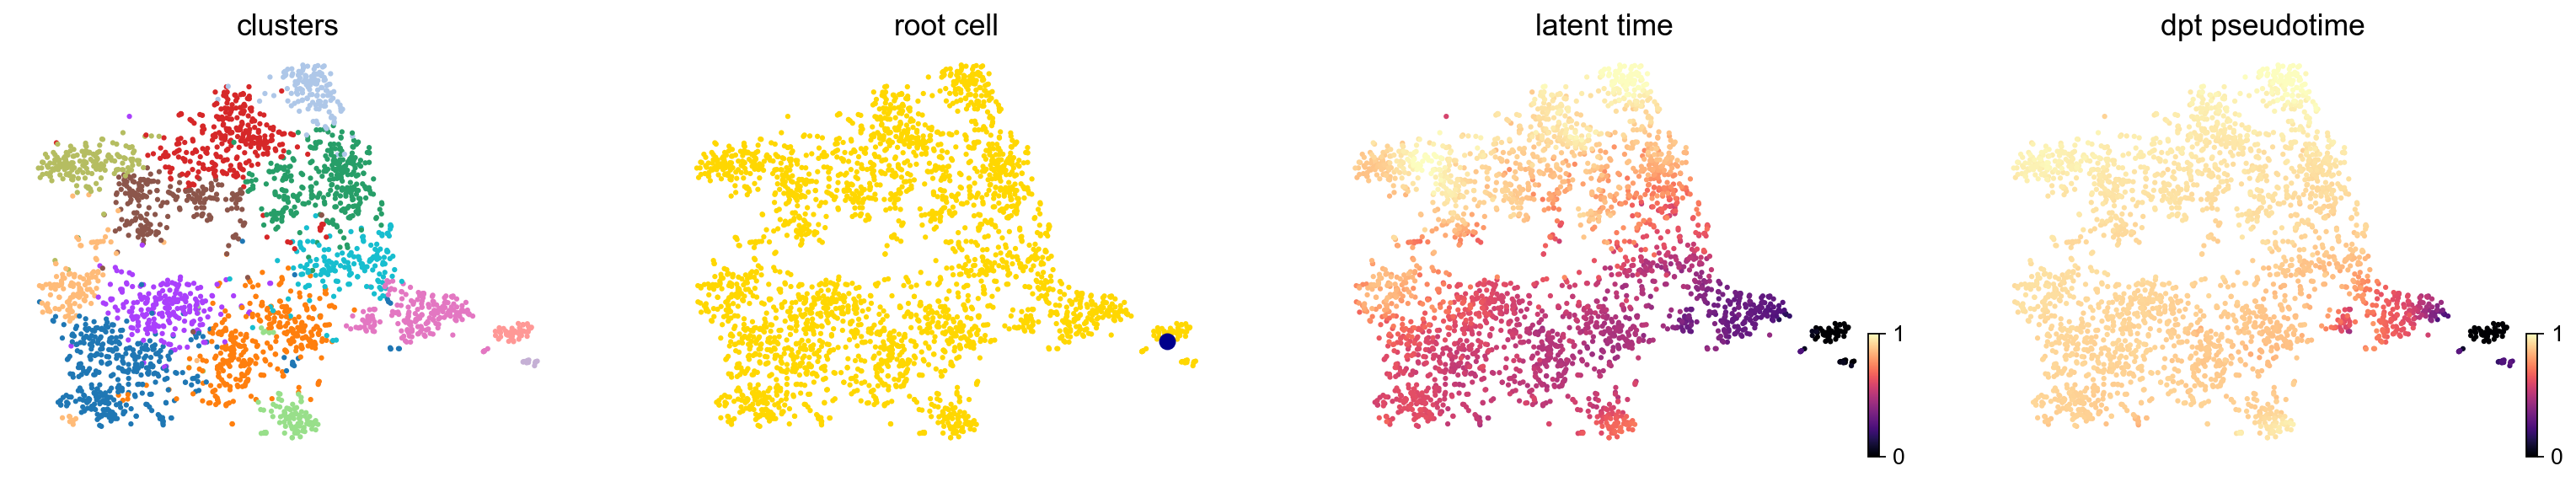

In [6]:
# compue dpt, starting from CellRank defined root cell
root_idx = np.where(adata.obs['initial_states'] == '12')[0][0]
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(adata, color=['louvain', root_idx, 'latent_time', 'dpt_pseudotime'], basis='tsne', fontsize=16,
               cmap='magma', perc=[2, 98], colorbar=True, rescale_color=[0, 1], 
               title=['clusters', 'root cell', 'latent time', 'dpt pseudotime'], save='cellrank_latent_time.pdf')

We can plot dynamics of genes in pseudotime along individual trajectories, defined via the fate maps we computed above.

In [3]:
cr.ul.models.GAM(adata)

GAM[GammaGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, max_iter=2000, scale=None, terms=s(0), tol=0.0001, verbose=False)]

In [4]:
model = cr.ul.models.GAM(adata)

Computing trends using `1` core(s)


did not converge
did not converge
did not converge
did not converge
did not converge
did not converge

    Finish (0:00:33)
Plotting trends


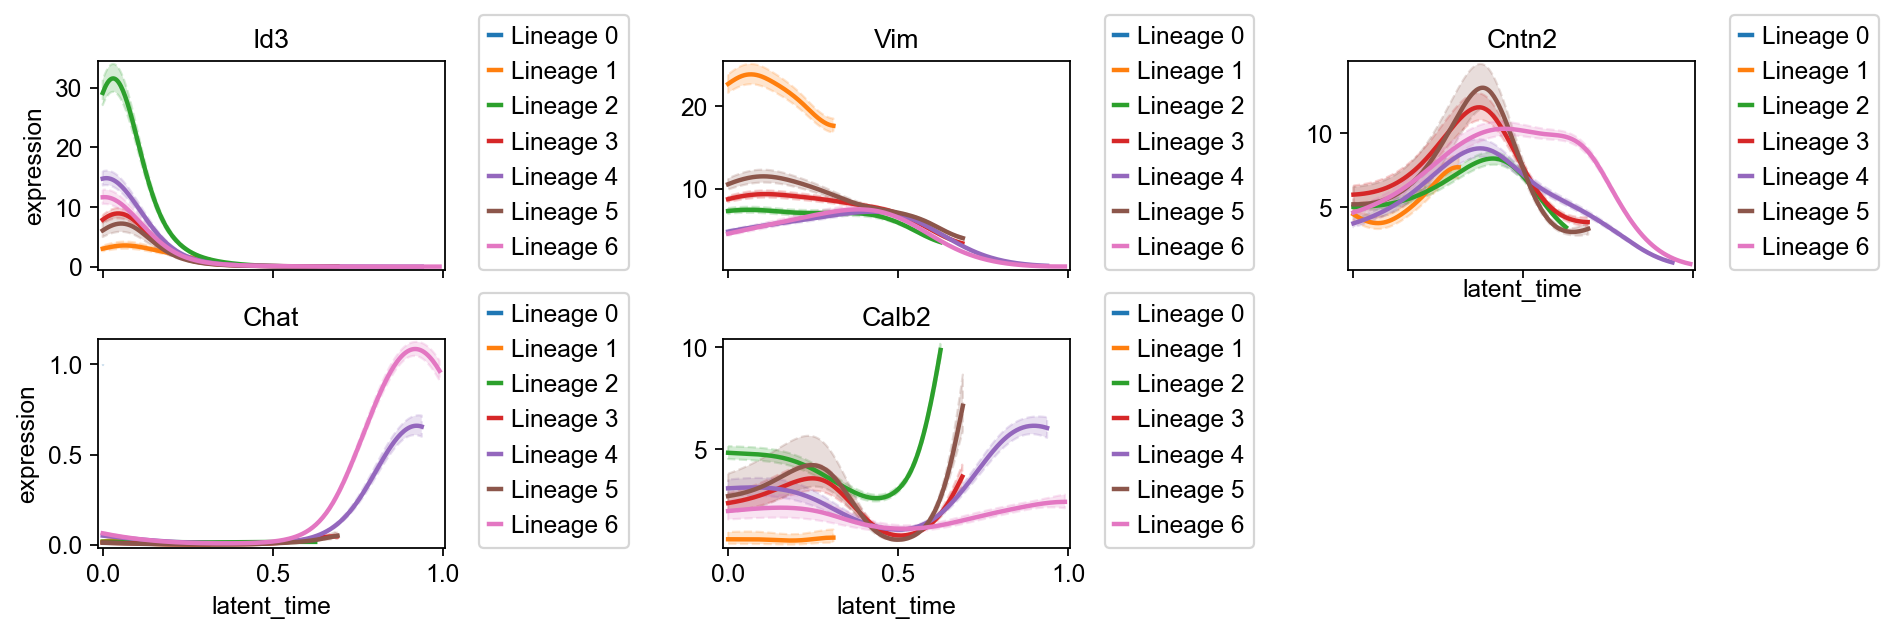

In [12]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Id3', 'Vim', 'Cntn2', 'Chat', 'Calb2'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                 legend_loc=(1.1 ,0),
                  figsize=(12,4), n_test_points=200, save= 'marker_gene_latent_time.pdf')

Computing trends using `1` core(s)


did not converge
did not converge

    Finish (0:00:11)
Plotting trends


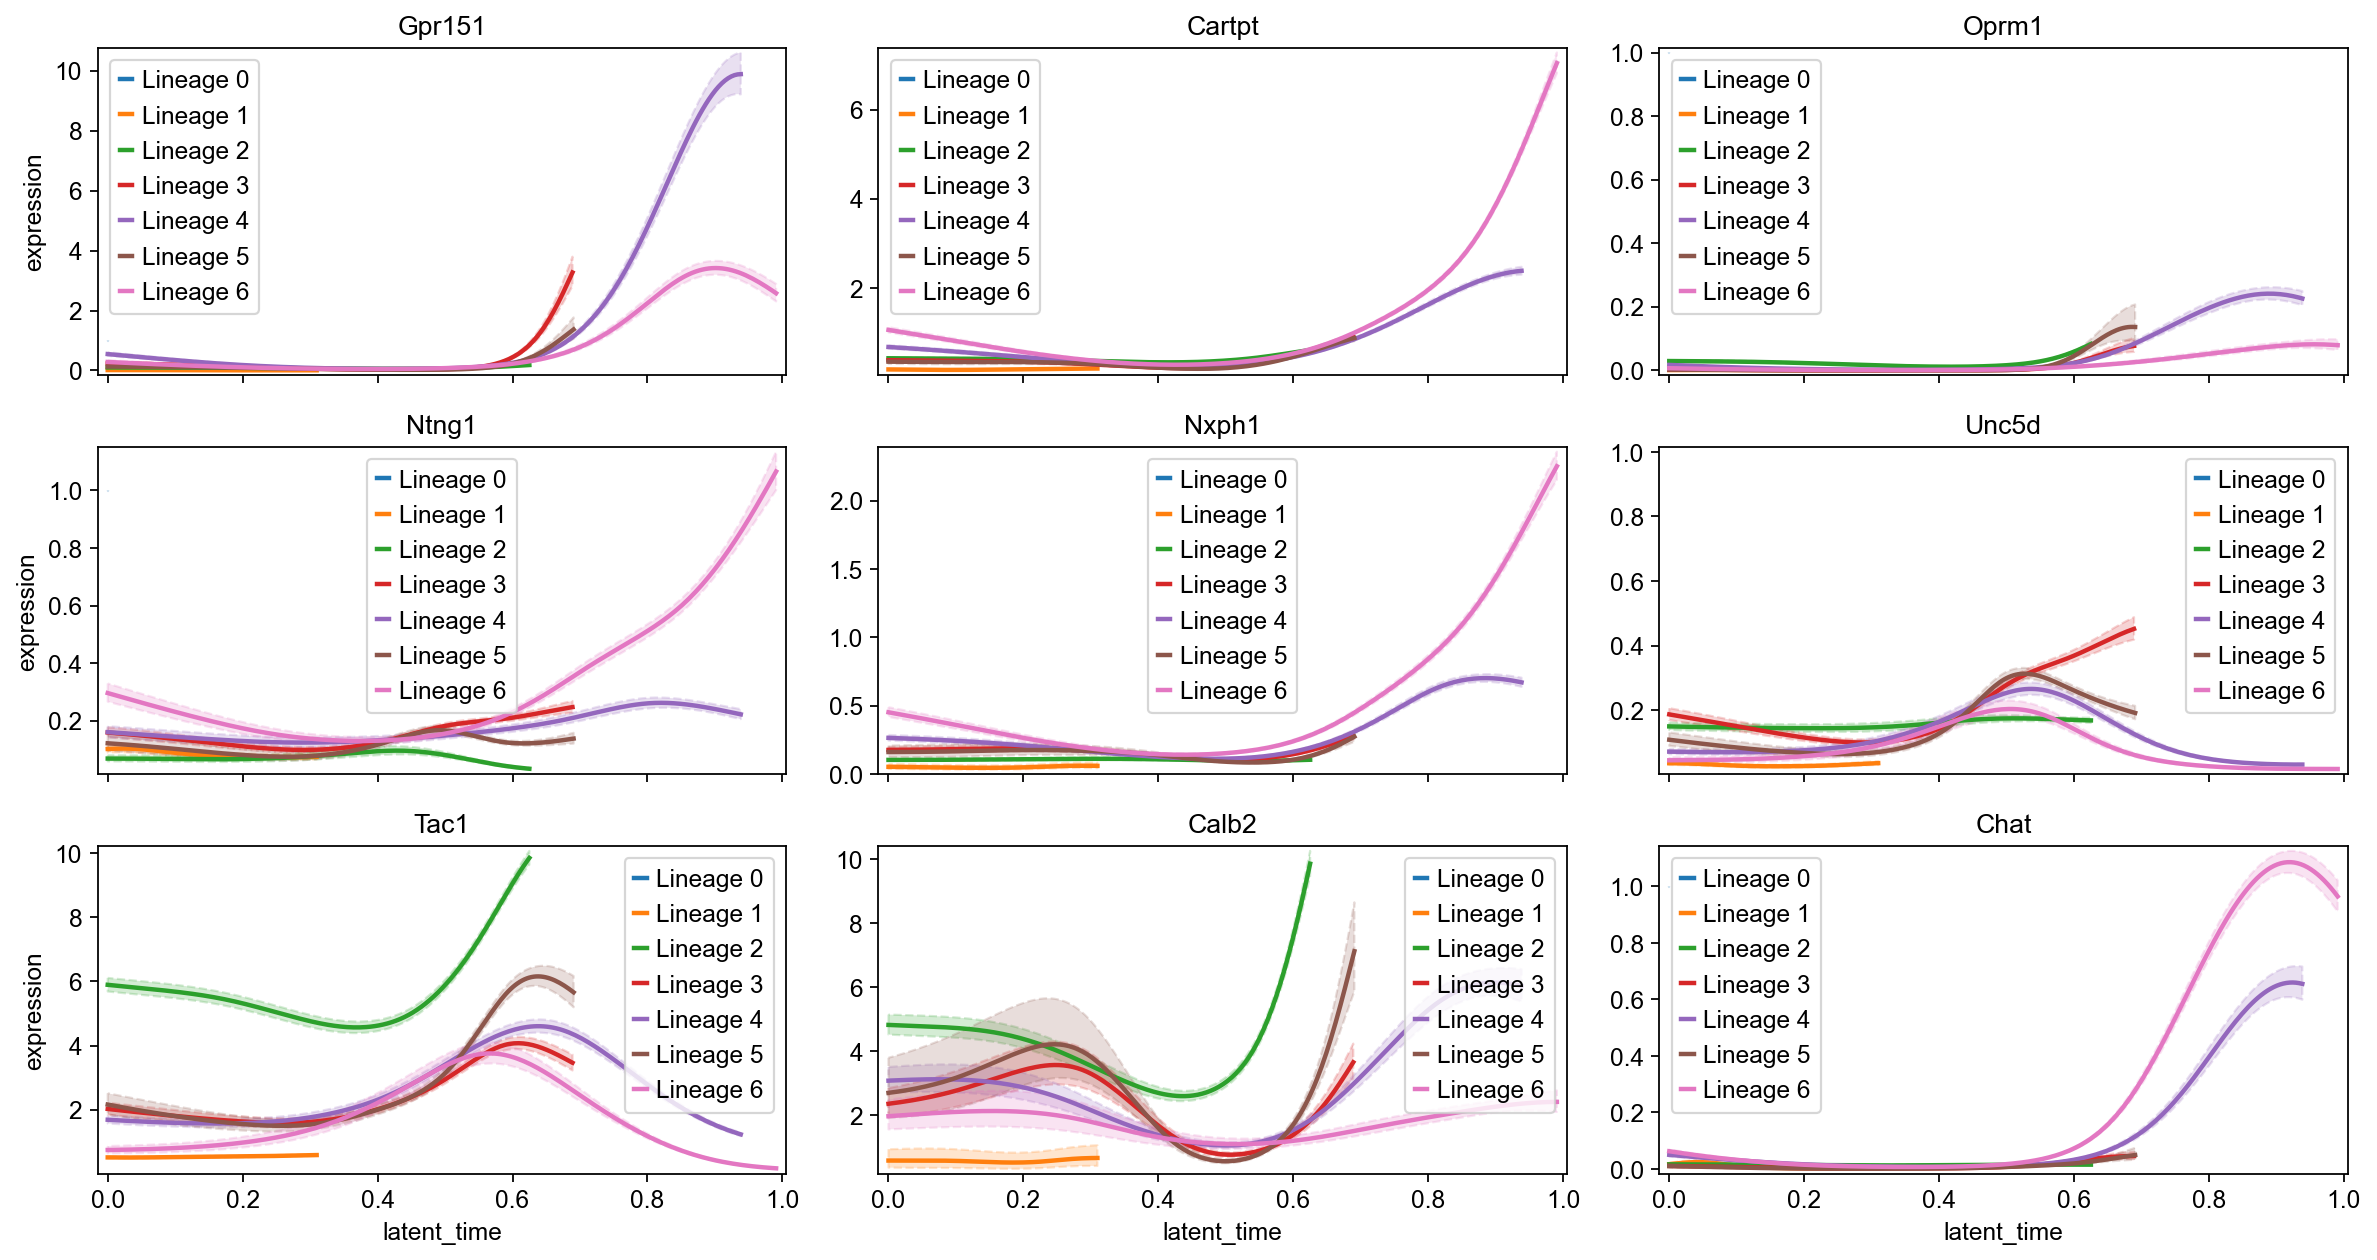

In [49]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Gpr151', 'Cartpt', 'Oprm1', 'Ntng1', 'Nxph1', 'Unc5d', 'Tac1', 'Calb2', 'Chat'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  figsize=(15, 8), n_test_points=200)

Computing trends using `1` core(s)


did not converge
did not converge
did not converge
did not converge
did not converge

    Finish (0:00:36)
Plotting trends


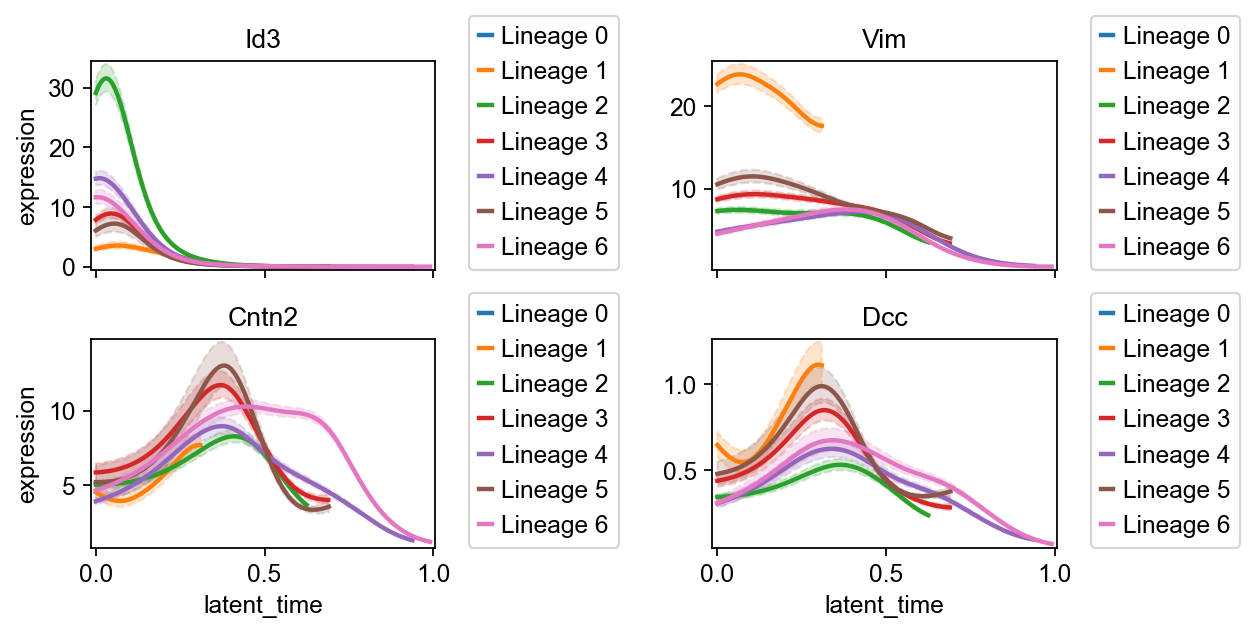

In [74]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=["Id3", 'Vim', 'Cntn2', 'Dcc'], ncols=2,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(8,4), n_test_points=200, save = "_developmental_expression.pdf")

Computing trends using `1` core(s)


did not converge

    Finish (0:00:09)
Plotting trends


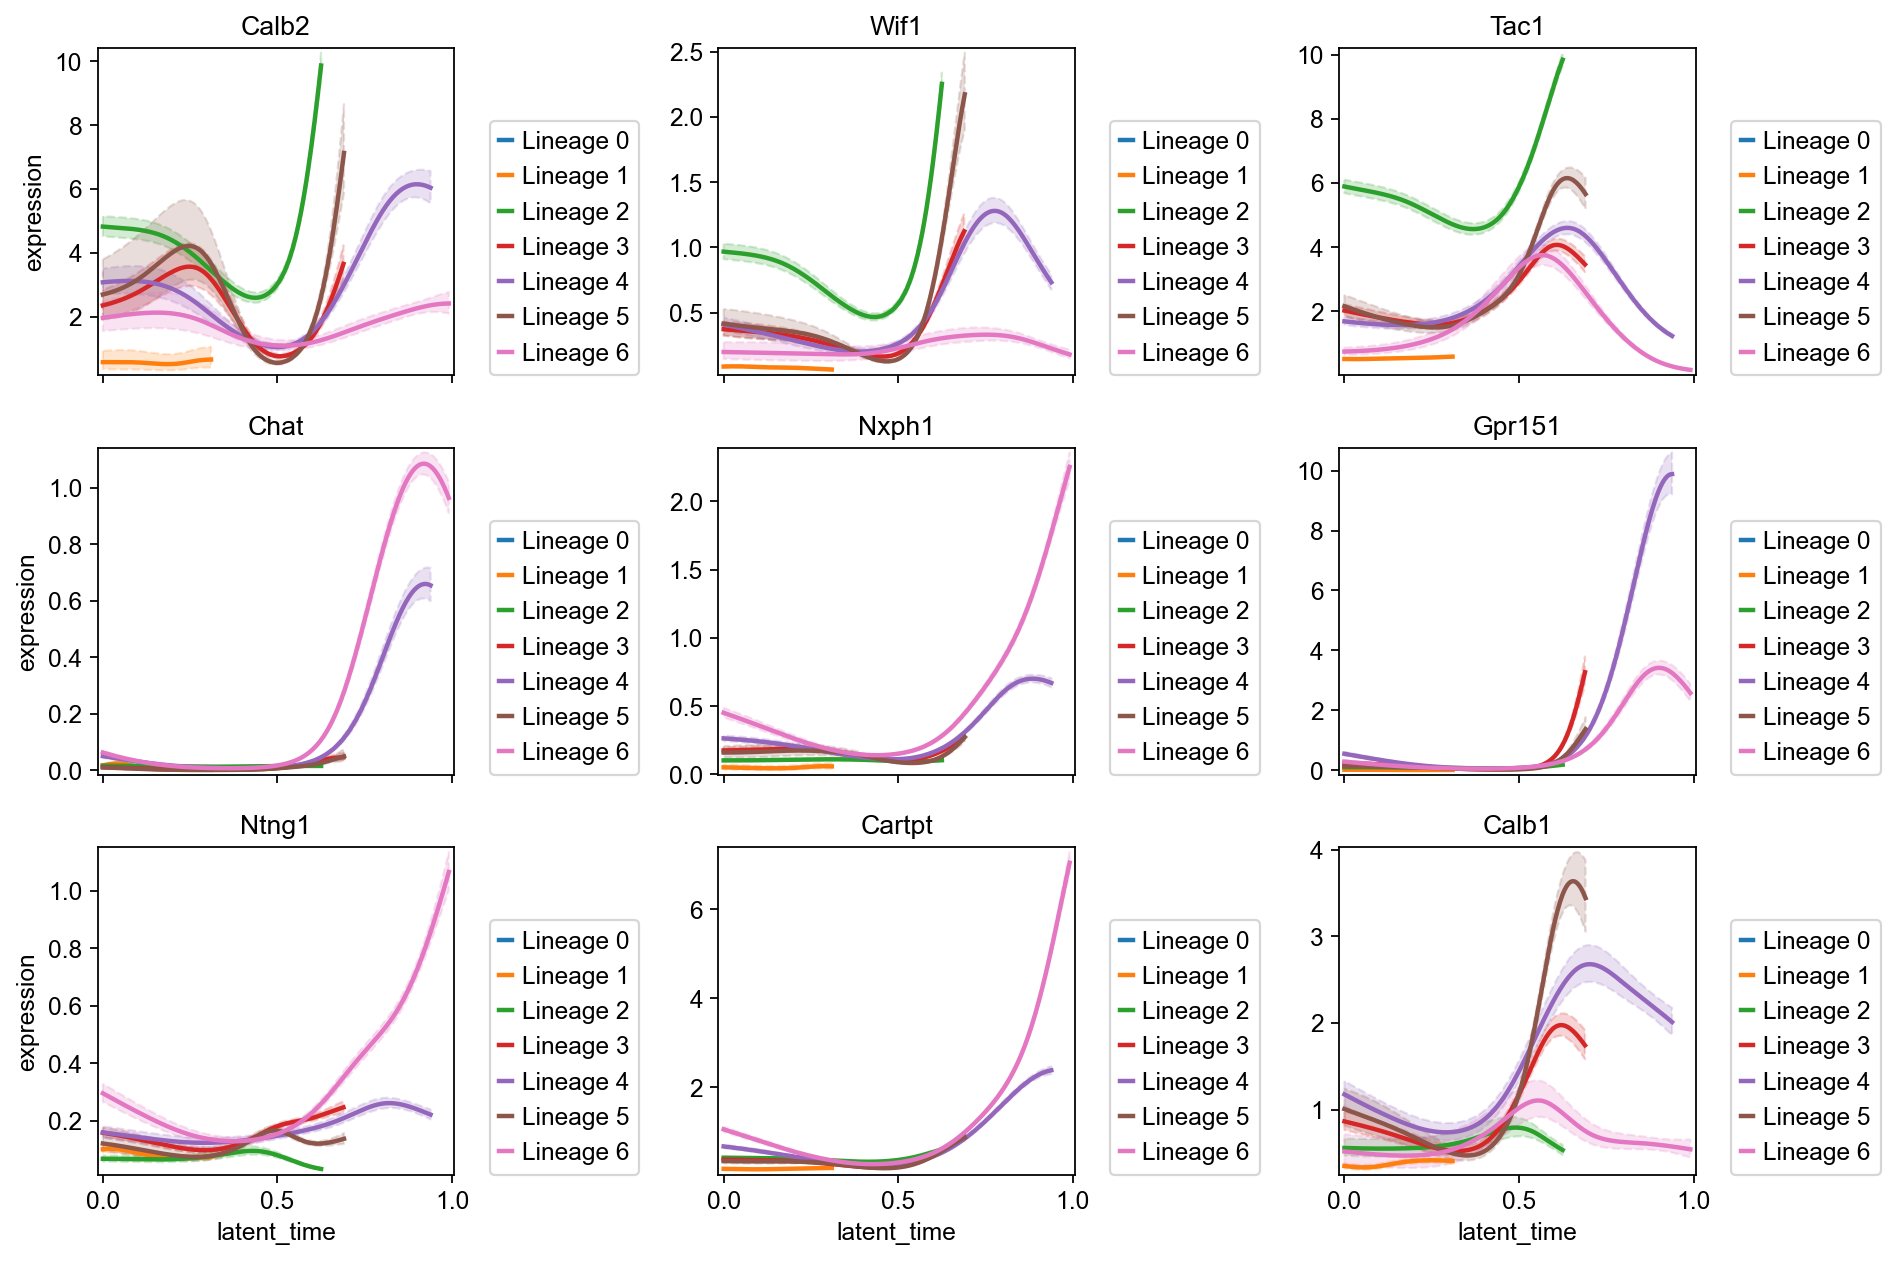

In [96]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Calb2', 'Wif1', 'Tac1',
                         'Chat', 'Nxph1','Gpr151', 'Ntng1', 'Cartpt', 'Calb1'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(12,8), n_test_points=200, save = "_Chat_Calb2.pdf")

Computing trends using `1` core(s)


did not converge
did not converge
did not converge
did not converge
did not converge

    Finish (0:00:31)
Plotting trends


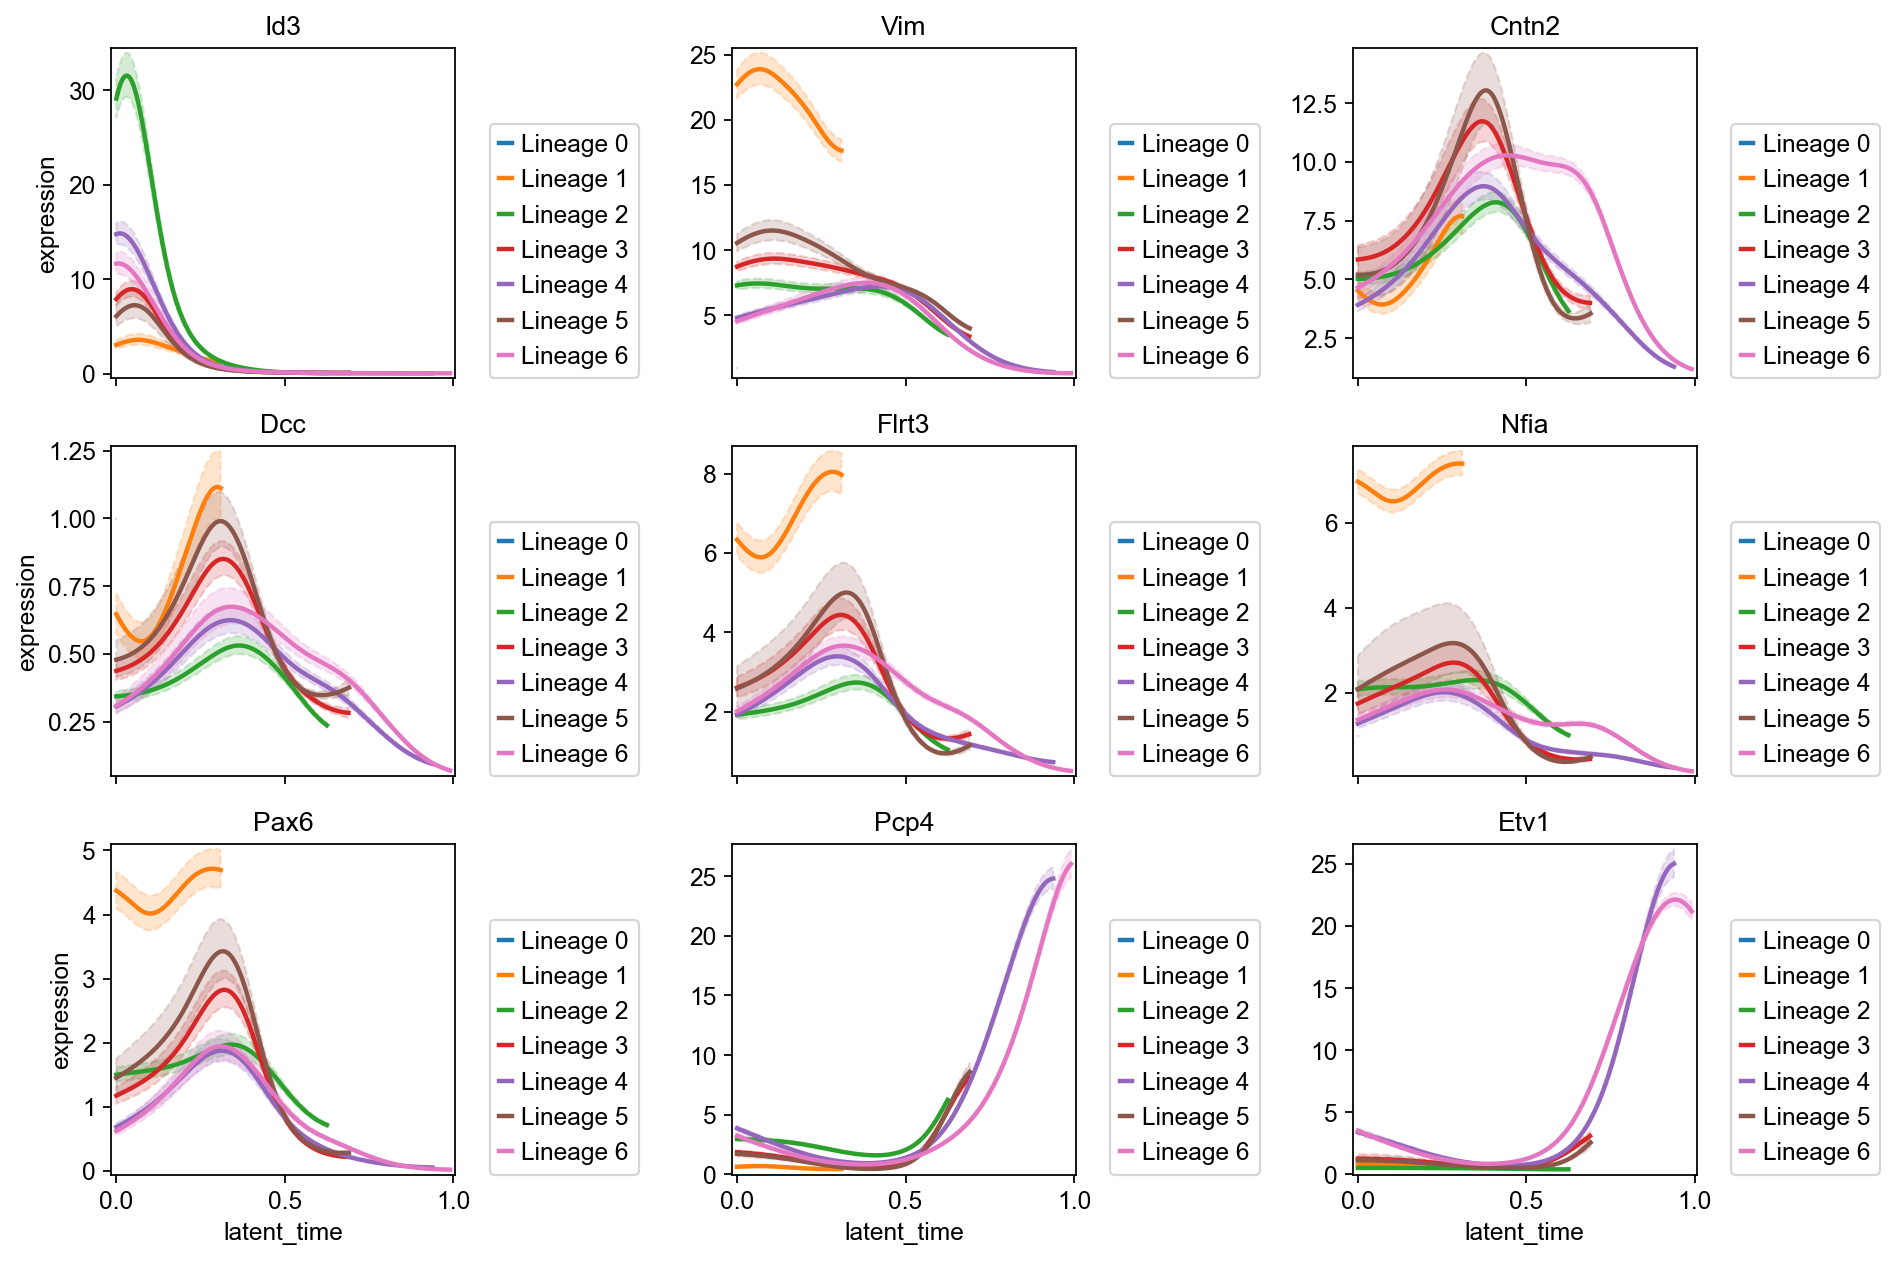

In [17]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Id3', 'Vim', 'Cntn2', 'Dcc', 'Flrt3', 'Nfia', 'Pax6', 'Pcp4', 'Etv1'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(12,8), n_test_points=200, save = "_development.pdf")

Computing trends using `1` core(s)



    Finish (0:00:01)
Plotting trends


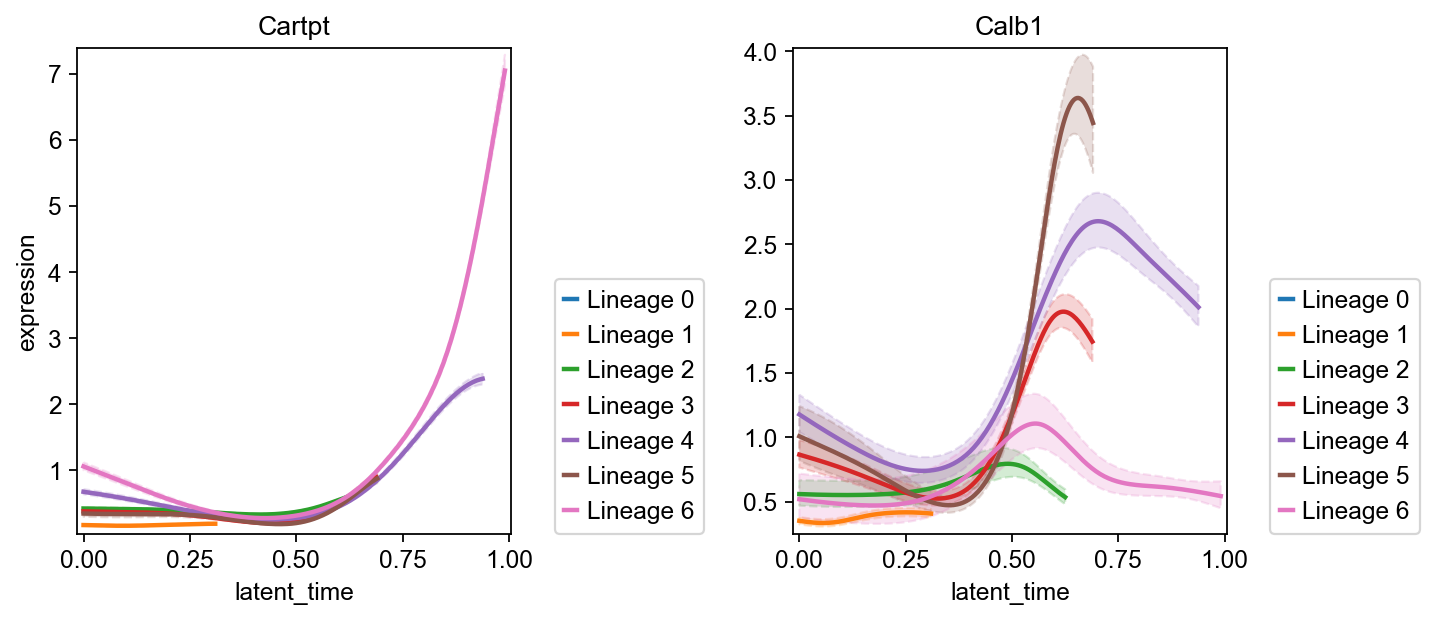

In [95]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Cartpt', 'Calb1'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(8,4), n_test_points=200, save = "_dorsal_ventral.pdf")

Computing trends using `1` core(s)



    Finish (0:00:02)
Plotting trends


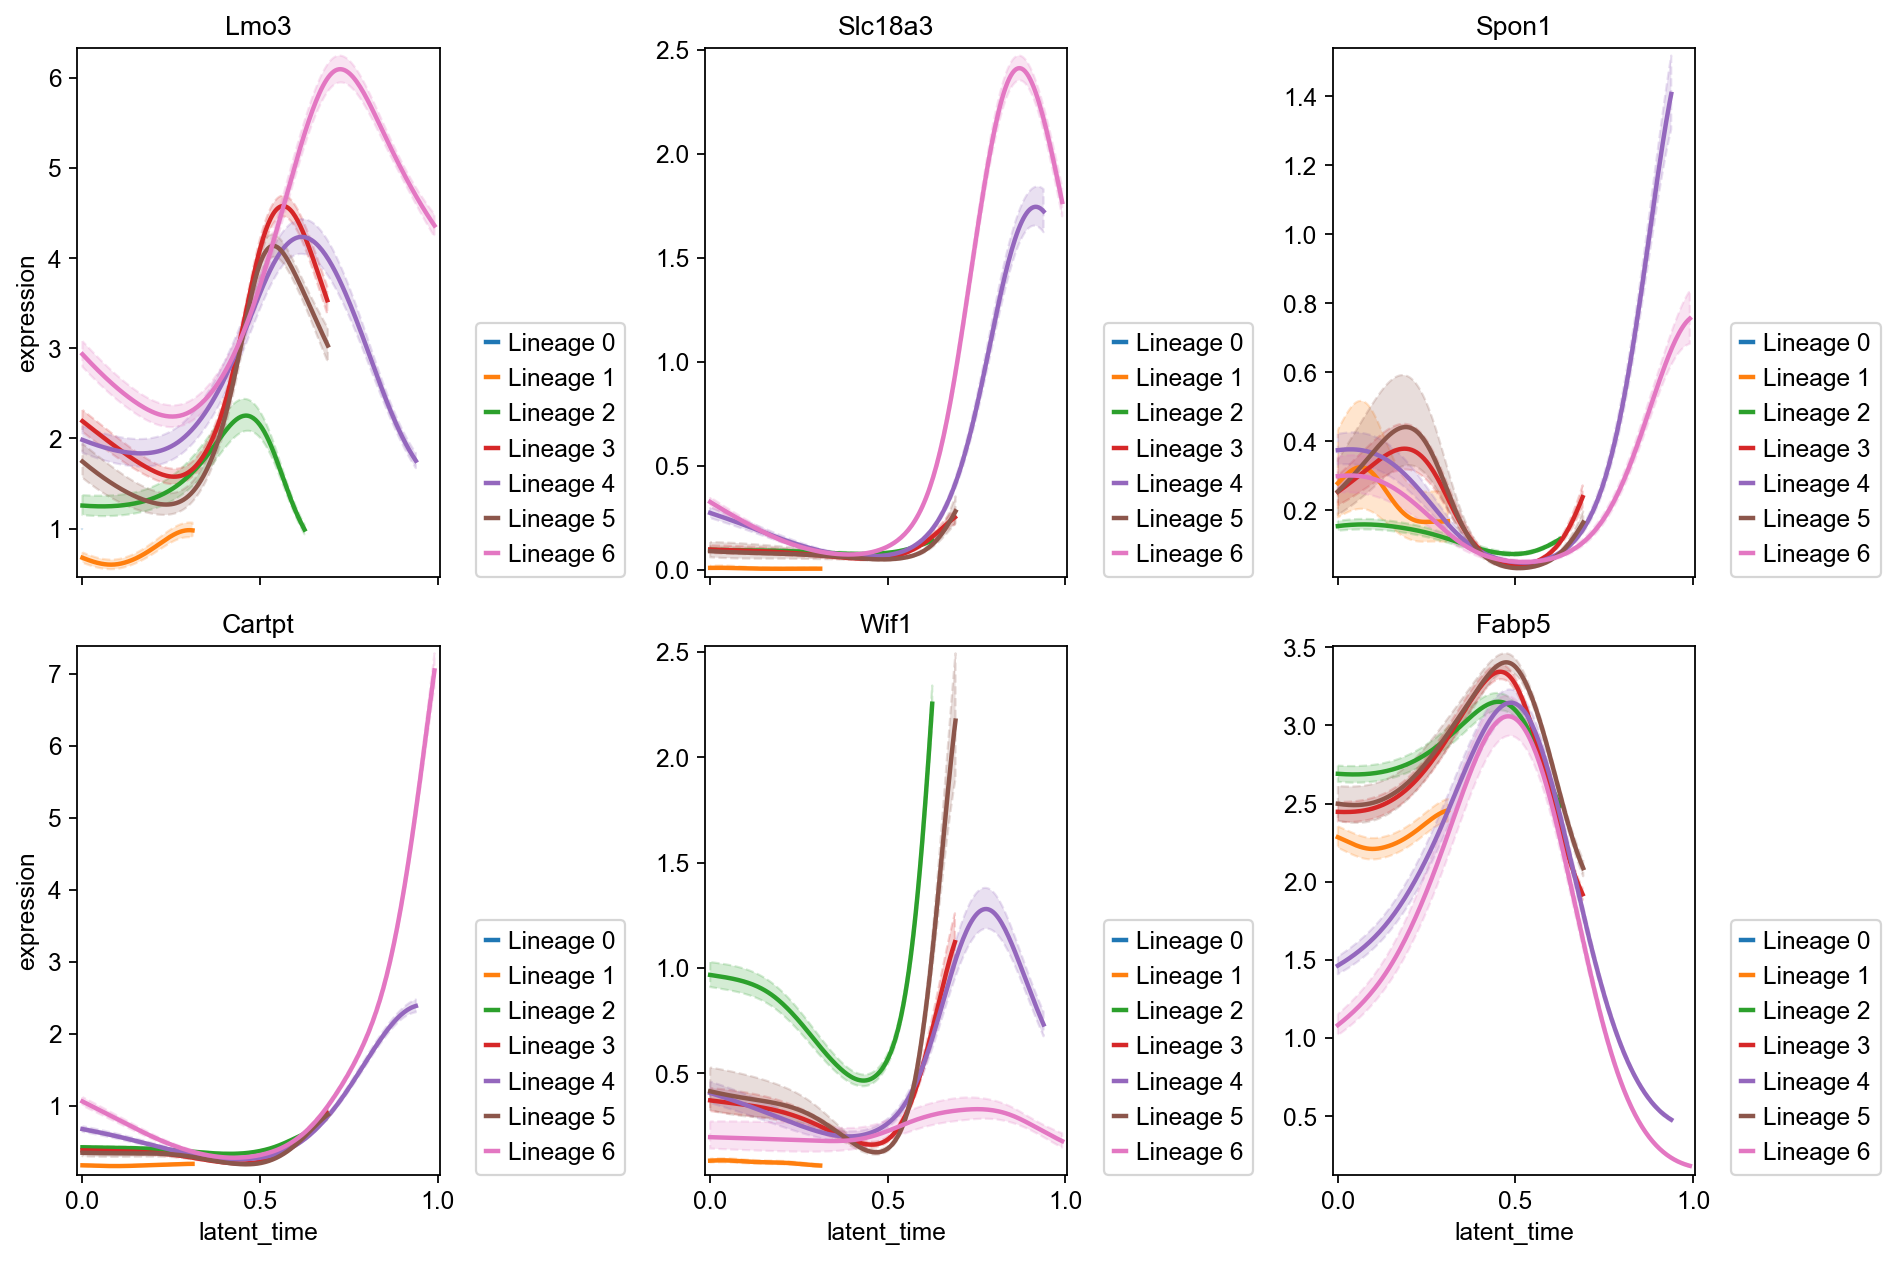

In [93]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Lmo3', 'Slc18a3', 'Spon1', 'Cartpt', 'Wif1', 'Fabp5'], ncols=3,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(12,8), n_test_points=200, save = "_Wallace_mHb.pdf")

Computing trends using `1` core(s)



    Finish (0:00:01)
Plotting trends


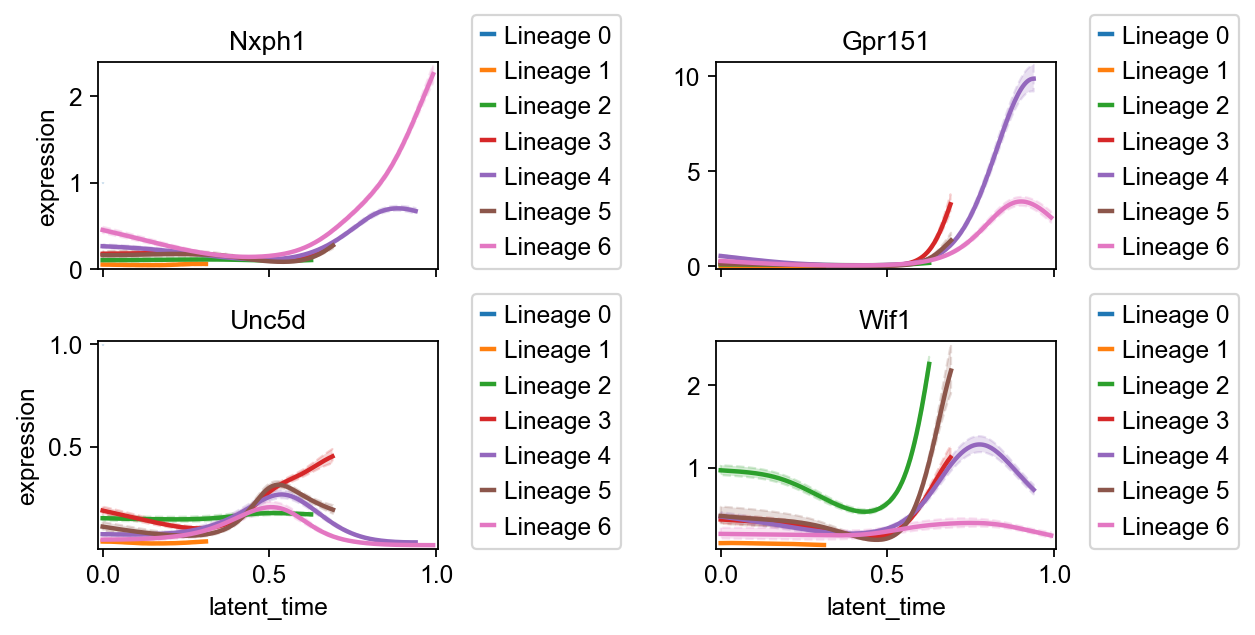

In [75]:
cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Nxph1','Gpr151', 'Unc5d', 'Wif1'], ncols=2,
                  time_key='latent_time', same_plot=True, hide_cells=True,
                  legend_loc=(1.1 ,0),
                  figsize=(8,4), n_test_points=200, save = "_Lineage_gene_trends_1.pdf")

We can also visualize the lineage driver computed above in a heatmap:

Computing trends using `1` core(s)
did not converge
did not converge
did not converge
    Finish (0:00:24)


Lineage 0 Lineage 1 Lineage 2 Lineage 3 Lineage 4 Lineage 5 Lineage 6
0        H19    Gabra2      Sox9      Cdh4      Sox9      Cdh4      Sox9
1       Klf6      Sox9     Ccnd2      Sox9       H19      Sox9     Ccnd2
2       Ngfr     Igsf5       H19       H19     Ccnd2       H19     Grasp
3      Igsf5      Cdh4     Grasp     Ccnd2     Grasp     Grasp       H19
4      Ccnd2      Drp2    Btbd17     Grasp    Btbd17     Ccnd2    Btbd17
5     Btbd17      Klf6      Sez6    Btbd17      Lhx2    Btbd17      Lhx2
6       Drp2       H19     Arvcf      Sez6      Sez6      Sez6      Ngfr
7       Lhx2   Zfp385a      Lhx2     Arvcf     Arvcf     Arvcf     Arvcf
8       Cdh4      Ngfr      Cdh4      Lhx2      Ngfr      Lhx2   Zfp385a
9      Arvcf     Ccnd2      Ngfr      Ngfr   Zfp385a      Ngfr      Sez6
10     Grasp      Lhx2   Zfp385a   Zfp385a      Klf6   Zfp385a      Klf6
11   Zfp385a    Btbd17      Drp2      Drp2     Igsf5      Drp2    Gabra2
12    Gabra2     Arvcf      Klf6      Klf6      Drp2      Klf6     Igsf5
13      Sox9     Grasp     Igsf5     Igsf5      Cdh4     Igsf5      Drp2
14      Sez6      Sez6    Gabra2    Gabra2    Gabra2    Gabra2      Cdh4

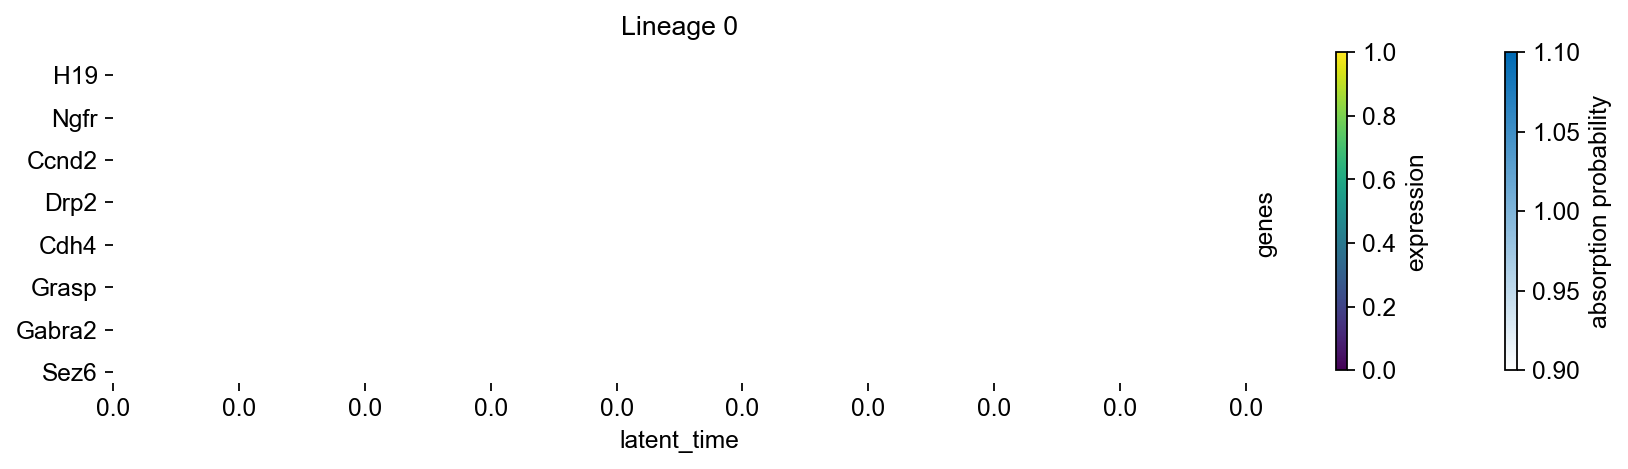

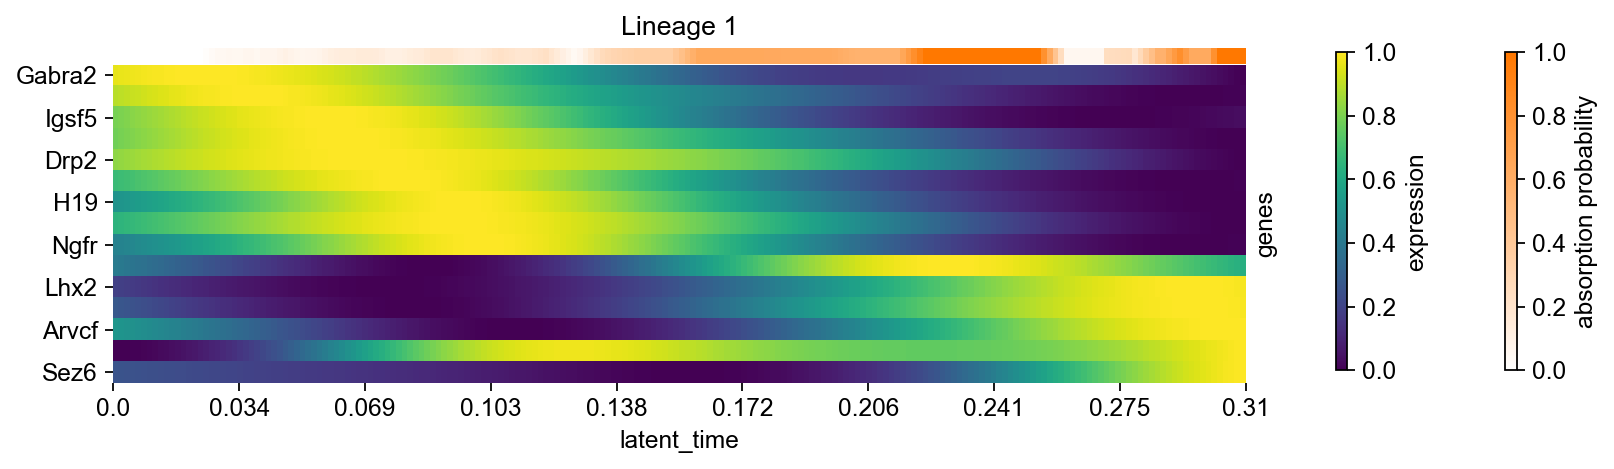

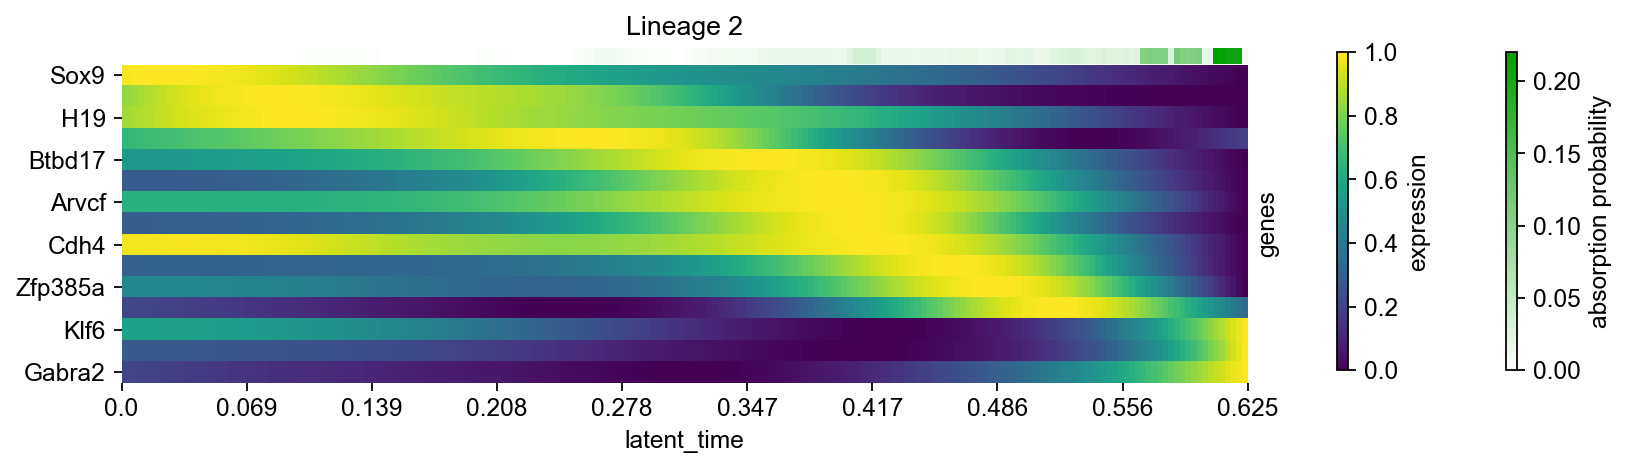

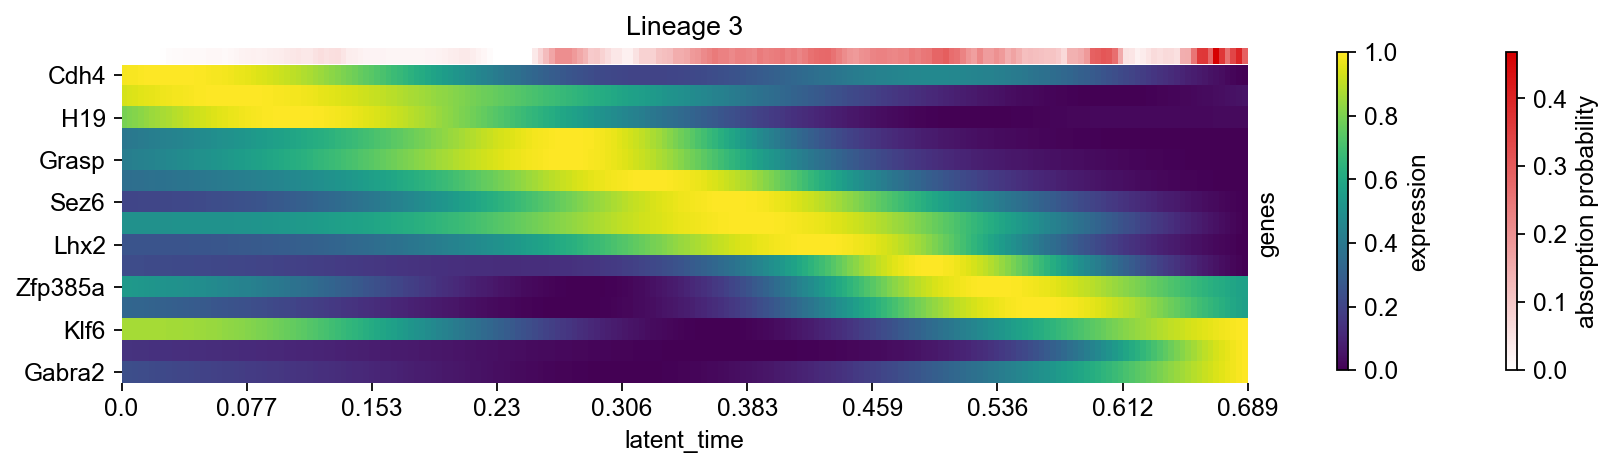

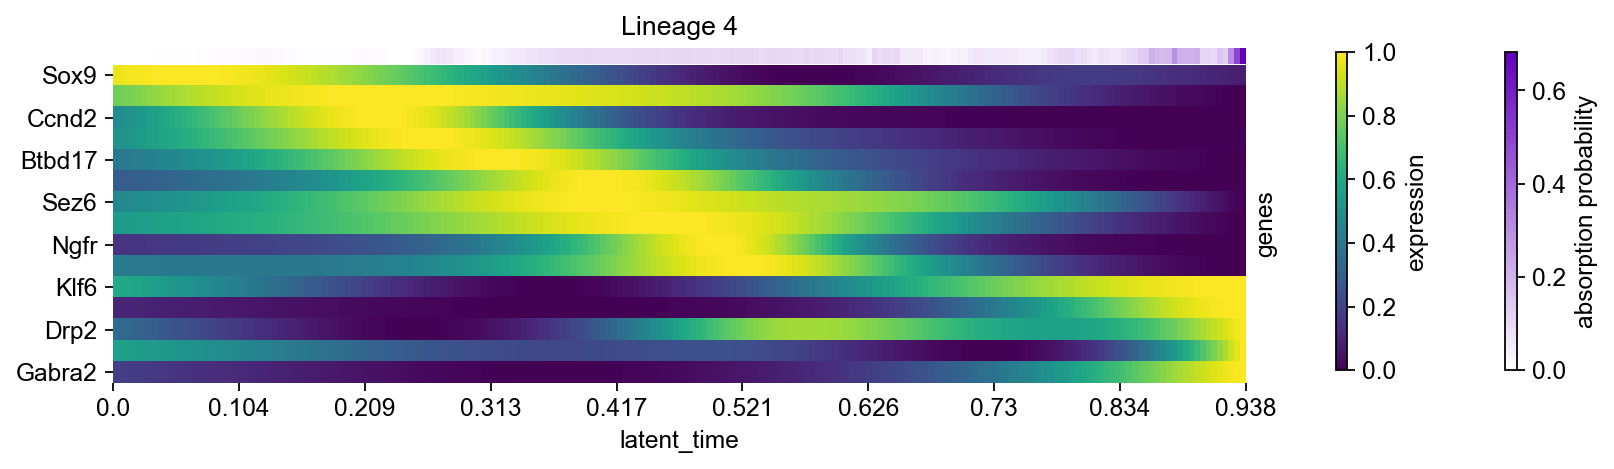

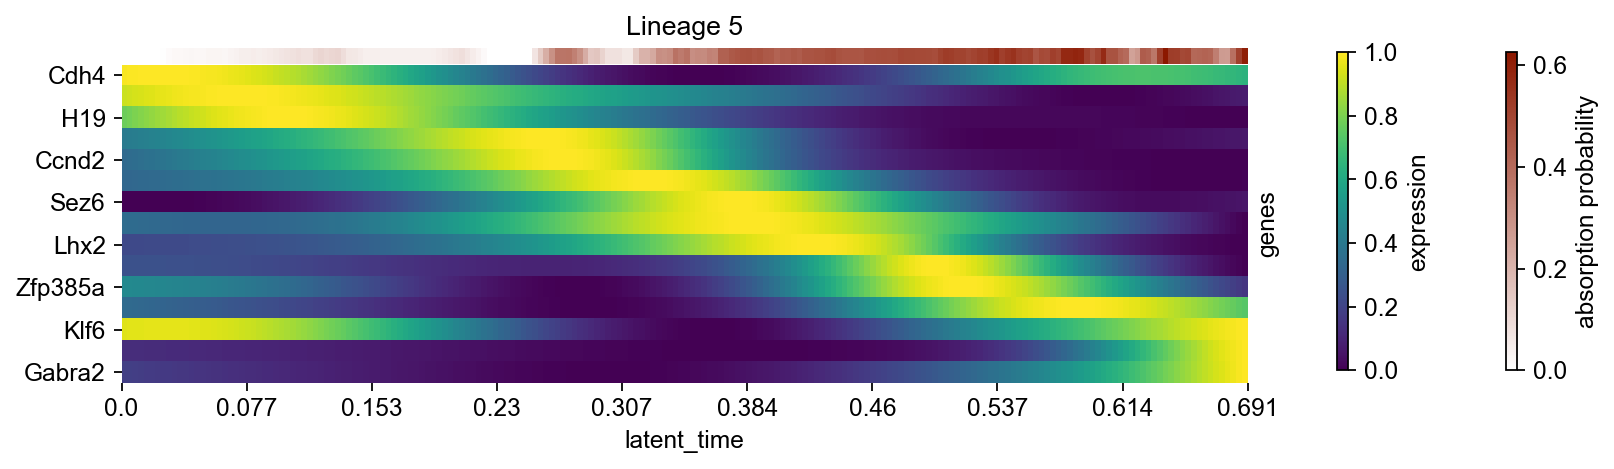

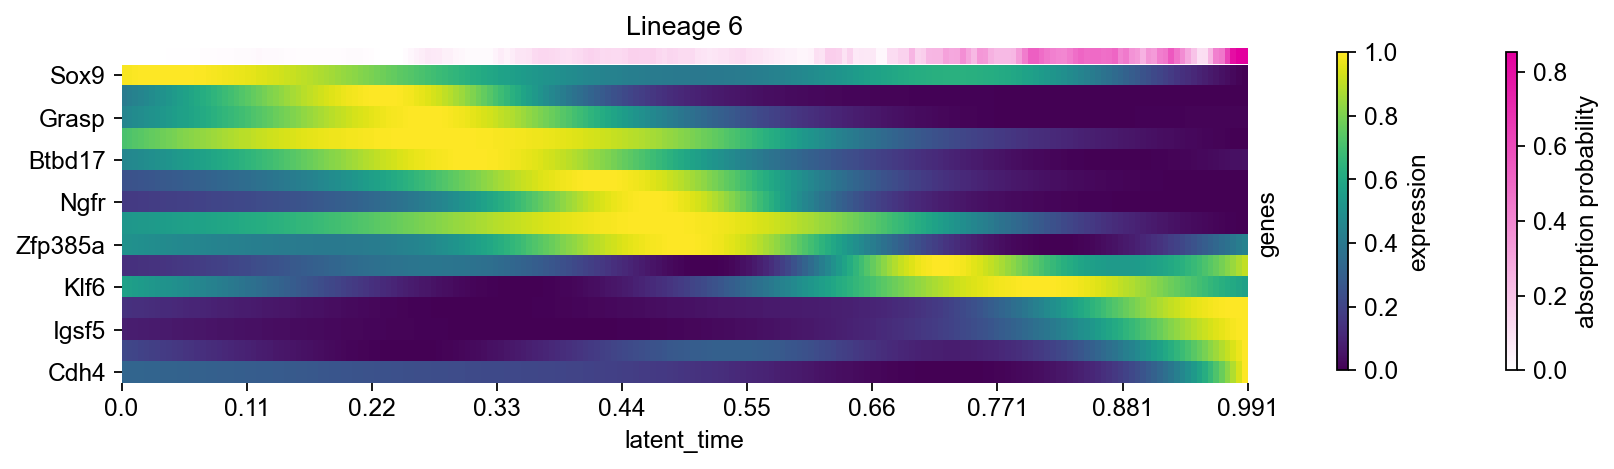

In [48]:
genes = cr.pl.heatmap(
    adata,
    model,
    adata.var_names[:15],
    time_key="latent_time",
    data_key='Ms',
    #lineages=["Lineage 0", "Lineage 1","Lineage 2", "Lineage 3", "Lineage 4"],
    show_absorption_probabilities=True,
    show_progress_bar=False,
    return_genes=True,
)
genes

In [ ]:
cr.pl.heatmap(adata, model, genes=adata.var['Lineage 1'].sort_values(ascending=False).index[:100],
              show_absorption_probabilities=True,
              lineages='Lineage 0', n_jobs=4, backend='loky')

In [103]:
adata.write('../../../data/output/DevelopmentalHb/Mar2020_embryo_Hb_Pou4f1_PCA_seurat_cellrank.h5ad')